In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from fem2D import Node, Element, plotMesh, readGmsh4, shapeFunctions, interp, readGLL, eraseCurrentMesh, plotNodesValues, plotMeshLimits, computeField

In [39]:
# chargement du maillage

eraseCurrentMesh()

# file = "../meshes/square2.msh"
# regions = [
#     (1, 31),
#     (1, 33),
#     (1, 32),
#     (1, 34),
#     ]

file = "../meshes/octogon4.msh"
regions = [
    (1, 21),
    (1, 23),
    (1, 22),
    (1, 24),
    ]


elements, nodes = readGmsh4(file, regions) 
dof = len(nodes)
print(f"{dof=}")

Info    : Reading '../meshes/octogon4.msh'...
Info    : 17 entities
Info    : 1505 nodes
Info    : 122 elements
Info    : Done reading '../meshes/octogon4.msh'
dof=1505


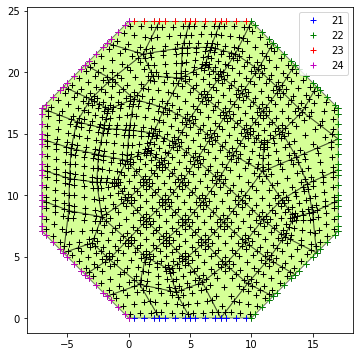

In [40]:
# plotMesh(elements, nodes, [31, 32, 33, 34], allNodes=True) 
plotMesh(elements, nodes, [21, 22, 23, 24], allNodes=True) 

In [41]:
# Chargement des points/poids d'intégration de GLL + dérivée des interpolateurs lagrangiens sur ces points

N = int(np.sqrt(len(elements[0].nodes))) - 1

if N == 1:
    raise(Exception("Please use classical FEM (linear) for order 1 mesh"))

xi,w,dh = readGLL(N)

print(f"{N=}")
print(f"{xi=}")

N=4
xi=array([-1.        , -0.65465367,  0.        ,  0.65465367,  1.        ])


In [42]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne
# La transformation depuis un élément quelconque vers l'élément de référence est l'interpolation bilinéaire

duphi = shapeFunctions["P1"]["duphi"]
dvphi = shapeFunctions["P1"]["dvphi"]

for e in elements:
    
    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]
    
    Je11 = np.zeros((N+1,N+1))
    Je21 = np.zeros((N+1,N+1))
    Je12 = np.zeros((N+1,N+1))
    Je22 = np.zeros((N+1,N+1))
    
    e.detJ = np.zeros((N+1,N+1))
    
    e.iJe11 = np.zeros((N+1,N+1))
    e.iJe21 = np.zeros((N+1,N+1))
    e.iJe12 = np.zeros((N+1,N+1))
    e.iJe22 = np.zeros((N+1,N+1))

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    for i in range(N+1):
        for j in range(N+1):
            
            Je11[i,j] = dxdu(xi[i], xi[j])
            Je21[i,j] = dxdv(xi[i], xi[j])
            Je12[i,j] = dydu(xi[i], xi[j])
            Je22[i,j] = dydv(xi[i], xi[j])
            
            e.detJ[i,j] = Je11[i,j]*Je22[i,j] - Je21[i,j]*Je12[i,j]
            
            e.iJe11[i,j] =  Je22[i,j]/e.detJ[i,j]
            e.iJe22[i,j] =  Je11[i,j]/e.detJ[i,j]
            e.iJe21[i,j] = -Je21[i,j]/e.detJ[i,j]
            e.iJe12[i,j] = -Je12[i,j]/e.detJ[i,j]

In [43]:
# calcul des matrices élémentaires

delta  = np.eye(N+1)

for e in tqdm(elements):
    
    # KeTemp = np.zeros((N+1,N+1,N+1,N+1))
    e.Ke = np.zeros(((N+1)**2,(N+1)**2))
    
    for i in range(N+1):
        for j in range(N+1):
            for k in range(N+1):
                for l in range(N+1):
                    
                    a = i*(N+1) + j
                    b = k*(N+1) + l
                                        
                    for p in range(N+1):
                        for q in range(N+1):                 

                            e.Ke[a,b] += w[p]*w[q] * ((e.iJe11[p,q]*dh[i,p]*delta[j,q] + e.iJe12[p,q]*dh[j,q]*delta[i,p])*(e.iJe11[p,q]*dh[k,p]*delta[l,q] + e.iJe12[p,q]*dh[l,q]*delta[k,p]) + (e.iJe21[p,q]*dh[i,p]*delta[j,q] + e.iJe22[p,q]*dh[j,q]*delta[i,p])*(e.iJe21[p,q]*dh[k,p]*delta[l,q] + e.iJe22[p,q]*dh[l,q]*delta[k,p])) * e.detJ[p,q]


100%|██████████| 90/90 [00:08<00:00, 10.47it/s]


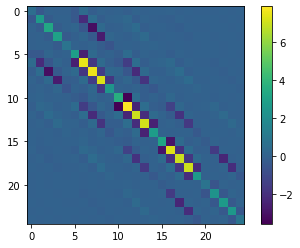

In [44]:
plt.imshow(elements[3].Ke)
plt.colorbar()

In [45]:
# assemblage

K = np.zeros((dof,dof))
F = np.zeros(dof)

for e in tqdm(elements):
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            K[n1.id,n2.id] += e.Ke[i,j]

100%|██████████| 90/90 [00:00<00:00, 1660.00it/s]


In [46]:
bot, top = 21, 23
Tbot, Ttop = 10.0, 30.0

for n in nodes:
    if n.region == bot:
        K[n.id,:] = 0
        K[n.id, n.id] = 1
        F[n.id] = Tbot
    if n.region == top:
        K[n.id,:] = 0
        K[n.id, n.id] = 1
        F[n.id] = Ttop

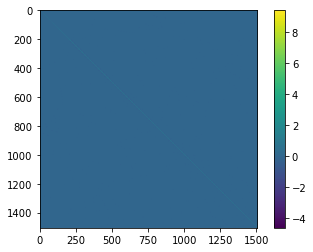

In [47]:
plt.imshow(K)
plt.colorbar()

In [48]:
# Résolution du système

U = np.linalg.solve(K, F)

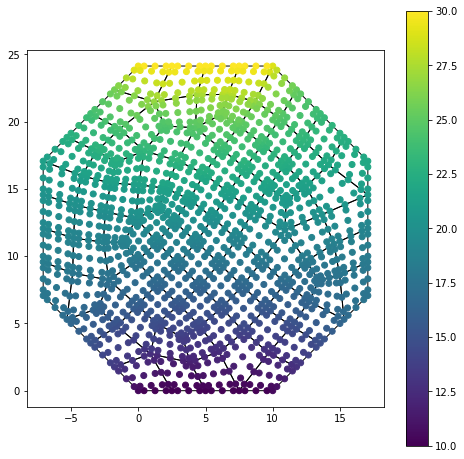

In [49]:
fig, ax = plt.subplots(figsize=(8,8))

plotNodesValues(U, nodes, ax)
plotMeshLimits(elements, ax)

In [59]:
hij = lagrangian2D(xi)

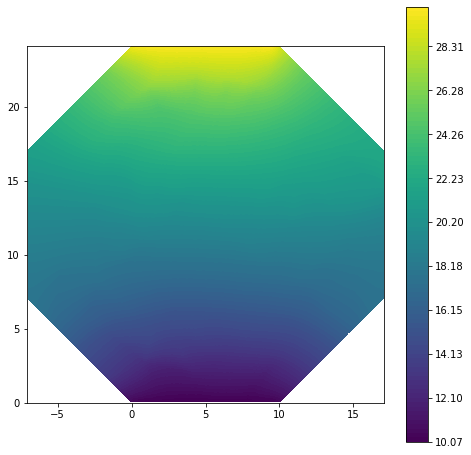

In [67]:

x,y,Uitp = computeField(U,nodes,elements,100)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")

im = ax.contourf(x,y,Uitp, levels = np.linspace(Uitp.min(),Uitp.max(),100))
plt.colorbar(im)
# plotMeshLimits(elements, ax)
# ax.contour(gridx,gridy,UitpMask, colors="r")